# Gaussian mixtures

In [174]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import geopandas
import xarray as xr

### Import the data

In [175]:
vars_vec = np.array(['HCP1QP', 'PRP1QP', 'HCP2QP', 'PRP2QP', 'HCP4QP', 'PRP4QP'], dtype=np.dtype(object))

raster_files = list("Interpolations/IDW_10" + vars_vec + ".tiff")

stack_xr = xr.open_rasterio(raster_files[0])
stack_xr = stack_xr.assign_coords(band=("band", [vars_vec[0]]))
stack_xr = stack_xr.where(stack_xr != -999.)
stack_data = stack_xr.to_dataset(dim="band")

i=1
for file in raster_files[1:12]:
    layer = xr.open_rasterio(file)
    layer = layer.where(layer != -999.)
    layer_data = layer.to_dataset(dim="band")
    stack_data[str(vars_vec[i])]= layer.squeeze()
    i += 1
    
stack_array = stack_data.to_array(dim="band")

df_raster = stack_data.to_dataframe()[vars_vec]

rows_with_nan = df_raster.isnull().any(axis=1)
df_nona = df_raster[~rows_with_nan]

## Theoretical background

A possible approach to the clustering of multivariate data is to assume that the data from each cluster has its own specific distribution and the observed data can thus be seen as the realization from a mixture of distributions. By making assumptions on the shape of these distributions the remaining parameters can be estimated by means of maximum likelihood estimation and with these estimated distributions it is then possible to determine to which cluster each observation is most likely to belong. Most commonly the clusters are assumed to be multivariate normally distributed and thus all data would be generated from a mixture of gaussian models. It is possible to further restrict the possible shapes of the distributions by making assumptions on the covariance matrix in each cluster. The four most common possibilities, which are implemented in scikit-learn are:
* **Spherical**: Covariance matrix is proportionnal to the identity matrix
* **Diagonal**: The non-diagonal elements of the covariance matrix equal 0, the elements on the diagonal are estimated by the algorithm
* **Tied**: The covariance matrix of each cluster is the same, all elements are estimated by the algorithm
* **Full**: All covariance matrices can be different and all elements are estimated by the algorithm


The estimation of the different components of the gaussian mixture model is done by means of the Expectation-Maximization algorithm and is implemented in the scikit-learn module in Python as GaussianMixture. By default the weights are initialized using k-means. It is also adviced to do multiple initializations of the algorithm and retain the best results, this reduces the risk of obtaining a local minimum (Shireman E. et al, 2017). Below the number of initializations is set to 10.

**References**\
[Fraley C.](https://academic.oup.com/comjnl/article-abstract/41/8/578/360856?redirectedFrom=fulltext), 1998.\
[Scikit-learn: Machine Learning in Python](https://jmlr.csail.mit.edu/papers/v12/pedregosa11a.html), Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.\
[Shireman E. et al, 2017](https://link.springer.com/article/10.3758/s13428-015-0697-6)

In [137]:
from sklearn.mixture import GaussianMixture

In [171]:
cv_types = ['spherical', 'tied', 'diag', 'full']
cluster_range = range(2,11)


bic = []
for cvtype in cv_types:
    for ncluster in cluster_range:
        
        model = GaussianMixture(n_components = ncluster, covariance_type=cvtype, n_init=10)
        model.fit(df_nona)
        bic.append(model.bic(df_nona))



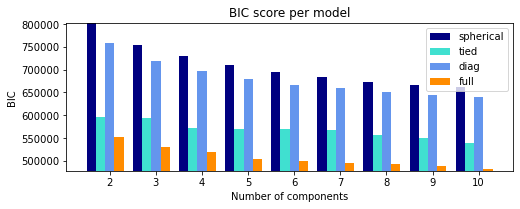

In [179]:
import itertools

bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
bars = []

# Plot the BIC scores
plt.figure(figsize=(8, 6))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(cluster_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(cluster_range):
                                  (i + 1) * len(cluster_range)],
                        width=.2, color=color))
plt.xticks(cluster_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
spl.set_xlabel('Number of components')
spl.set_ylabel('BIC')
spl.legend([b[0] for b in bars], cv_types)
plt.show()

The BIC is used as an indicator for goodness-of-fit of the mixture model and should be minimized. Again the BIC keeps decreasing as more components are added, so there is no clear optimum in number of components to the mixture distribution.\
Clearly, leaving all parameters of each multivariate normal free results in the model with the smallest BIC.  This means that each 'cluster' has a different covariance structure between the variables.\
Since is no optimum in the BIC, we choose for the two most promising coveriance types, the number of components at which the BIC stabilizes. That means the classification with 5 components and a full covariance type as well as the classification with 4 components and a tied covariance type are implemented below.

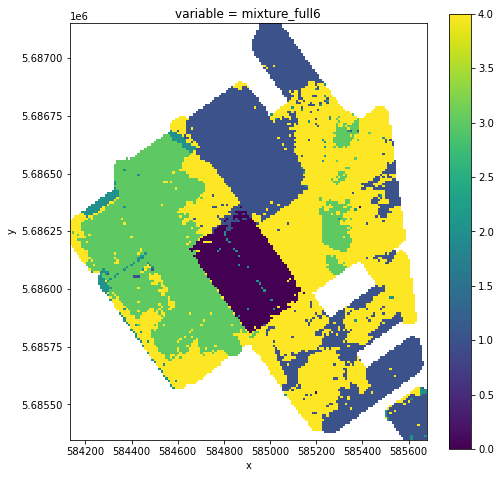

In [176]:
fullmodel_n6 = GaussianMixture(n_components = 5, covariance_type='full', n_init=10).fit(df_nona)
clusters = fullmodel_n6.predict(df_nona) # each pixel assigned to cluster that has largest probability

cl = np.empty((27540))
cl[:] = np.nan

cl[~rows_with_nan] = clusters

df_raster['mixture_full6'] = cl

xr_clusters = df_raster.to_xarray().transpose('y', 'x')
cl_array = xr_clusters.to_array()
ax = cl_array.sel(variable='mixture_full6').plot.pcolormesh(figsize=(8,8))
ax.axes.set_aspect('equal')

Since this is a model based approach, also indicators for the uncertainty of the classification of a certain observation can be derived. For each observations, estimations of the probability of belonging to each cluster are calculated. The observation is then classified to the cluster for which the respective probability is largest. This probability should be as high as possible to have little uncertainty on the classification. To learn about the spatial distribution of the uncertainty of the classification, this maximal probability can be plotted by its respective coordinates.

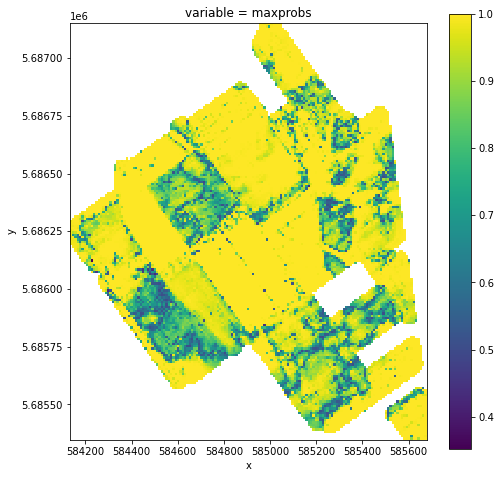

In [177]:
probs = fullmodel_n6.predict_proba(df_nona)
maxprobs = probs.max(axis=1)

cl = np.empty((27540))
cl[:] = np.nan
cl[~rows_with_nan] = maxprobs
df_raster['maxprobs'] = cl

xr_clusters = df_raster.to_xarray().transpose('y', 'x')
cl_array = xr_clusters.to_array()
ax = cl_array.sel(variable='maxprobs').plot.pcolormesh(figsize=(8,8))
ax.axes.set_aspect('equal')

Having the full covariance matrix fitted in the process is very flexible, but prone to overfitting. It could detect clusters that are due to drift of the instrument and therefore creates clusters that are not interesting for interpretation of the data. Comparing the map above with the surveys shows that an influence of drift might indeed be true.

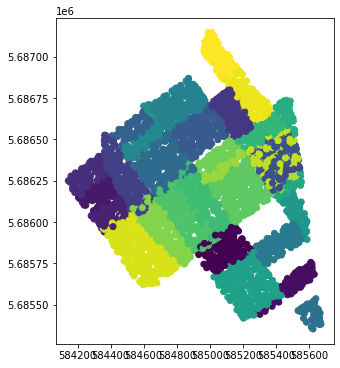

In [182]:
gdf5000 = geopandas.read_file('../Data/Data_geojson/gdf5000.geojson')
gdf5000.plot(column='survey', figsize=(6,6))
plt.show()

For this reason it may be a better option impose more restrictions on the mixture model. The model with a tied covariance matrix, i.e. elliptical clusters with the same covariance structure for each cluster, also performed well and its BIC had a local minimum for 6 clusters as well. 

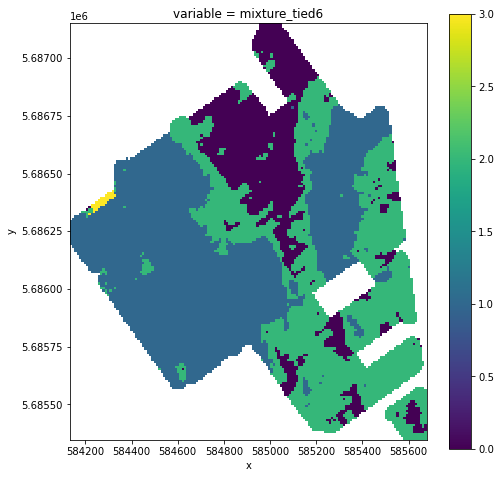

In [178]:
tiedmodel_n6 = GaussianMixture(n_components = 4, covariance_type='tied', n_init=10).fit(df_nona)
clusters = tiedmodel_n6.predict(df_nona) # each pixel assigned to cluster that has largest probability

cl = np.empty((27540))
cl[:] = np.nan

cl[~rows_with_nan] = clusters

df_raster['mixture_tied6'] = cl

xr_clusters = df_raster.to_xarray().transpose('y', 'x')
cl_array = xr_clusters.to_array()
ax = cl_array.sel(variable='mixture_tied6').plot.pcolormesh(figsize=(8,8))
ax.axes.set_aspect('equal')

This classification makes more sense in how it reflects the global trends in the data. It clearly clusters according to the trend from high to low ECa, it would be interesting to see if some of its classes are also due to more subtle differences in EMI response.\
**Maybe compare with a map of the first PC to see if it is only reflecting this trend or more (in some runs, also other patterns are observed)**


**Also compare it to a k-means with n=6?**

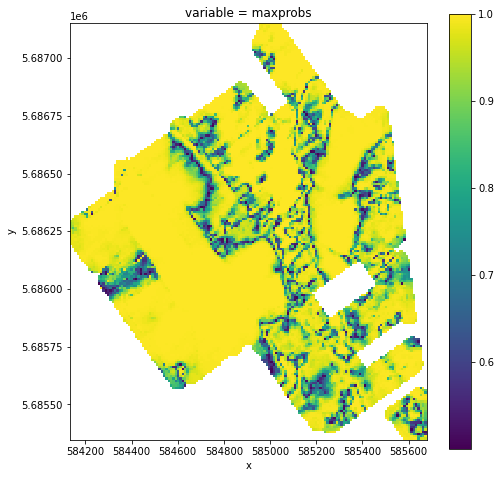

In [180]:
probs = tiedmodel_n6.predict_proba(df_nona)
maxprobs = probs.max(axis=1)

cl = np.empty((27540))
cl[:] = np.nan
cl[~rows_with_nan] = maxprobs
df_raster['maxprobs'] = cl

xr_clusters = df_raster.to_xarray().transpose('y', 'x')
cl_array = xr_clusters.to_array()
ax = cl_array.sel(variable='maxprobs').plot.pcolormesh(figsize=(8,8))
ax.axes.set_aspect('equal')

This shows that a large area is homogeneous and can easily be clustered. The transition to the area with a higher conductivity is more difficult to cluster. This is evident if the transition is gradual without an clear indication of where to put the cluster boundaries.

## Reflection on the assumptions of the 'tied' covariance type

Do assumptions of 'tied' covariance matrices make sense? This means that for all clusters, the covariances between the variables are the same. This could make sense since they are strongly correlated because there is a volume of soil that is measured by all of them.

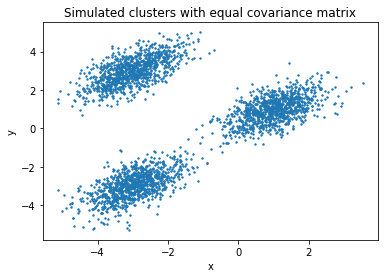

In [146]:
from numpy.random import multivariate_normal as rnorm
centers = np.array([[1,1],[-3,3],[-3,-3]])
cov = np.array([[0.5,0.3],[0.3,0.5]])
x1 = rnorm(centers[0], cov, size=1000)
x2 = rnorm(centers[1], cov, size=1000)
x3 = rnorm(centers[2], cov, size=1000)
toy  = np.array([row for row_group in zip(x1, x2, x3) for row in row_group])

plt.scatter(x=toy[:,0], y=toy[:,1], s=2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Simulated clusters with equal covariance matrix')
plt.show()

In [147]:
model = GaussianMixture(n_components = 3, covariance_type='tied').fit(toy)

group_pred = model.predict(toy).astype(int)

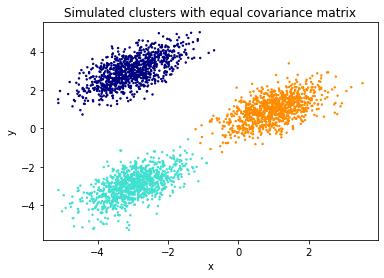

In [148]:
colors = np.array(['navy', 'turquoise', 'darkorange'])
plt.scatter(x=toy[:,0], y=toy[:,1], s=2, color=colors[group_pred])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Simulated clusters with equal covariance matrix')
plt.show()

It are these kinds of patterns that can be easily recognized by the EM-algorithm starting with the assumption of multivariate normal clusters with an equal covariance matrix. The question then remains whether such assumption is reasonable for the EMI dataset. As mentioned earlier, the correlations between the considered variables are all high by nature since there is a shared soil volume that is influences the measurement of all 6 variables. A better understanding might be obtained when interpreting the above toy dataset as if it were an EMI dataset. With x and ECa measurement with DOI of 1m and y and ECa measurement with DOI of 2m for example. The two clusters on the left of the plot are then clusters with a relatively low ECa in the upper layer but are different from each other since one cluster has material of higher conductivity between 1m and 2m depth. The correlation between both variables in both clusters is then due to variations in conductivity up to 1m depth that influence both measurements. The cluster on the right then depicts observations with a higher conductivity in the surface layers as compared to the other to clusters.\
Theoretically this method is thus well suited to detect differences in stratigraphy observed from EMI data and accounts for the correlational structure between the variables.

In our specific dataset though, a clear clustering as in the toy example is not the case. That could already be observed when inspecting the scatterplot of the first 2 principal components and can also be observed when making scatterplots with different combinations of the variables. Also from the resulting classification it was clear that it rather reflects the general trend in conductivity of the soil rather than differences in stratigraphy, since such difference are probably subtle in this dataset and not explicitly deducable from the dataset.

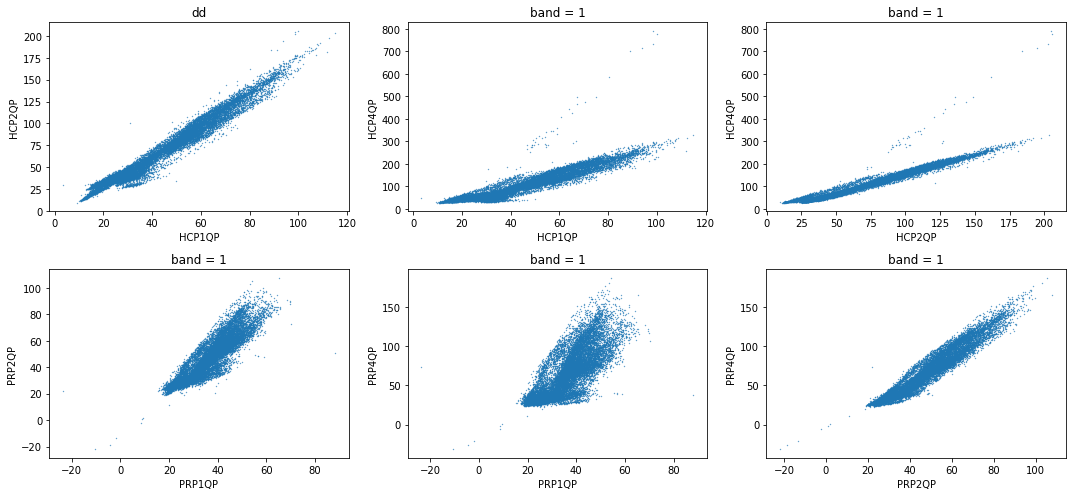

In [187]:
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(2,3, figsize=(15,7))

stack_data.plot.scatter(x='HCP1QP', y='HCP2QP', s=0.1, ax=ax0)
stack_data.plot.scatter(x='HCP1QP', y='HCP4QP', s=0.1, ax=ax1)
stack_data.plot.scatter(x='HCP2QP', y='HCP4QP', s=0.1, ax=ax2)
stack_data.plot.scatter(x='PRP1QP', y='PRP2QP', s=0.1, ax=ax3)
stack_data.plot.scatter(x='PRP1QP', y='PRP4QP', s=0.1, ax=ax4)
stack_data.plot.scatter(x='PRP2QP', y='PRP4QP', s=0.1, ax=ax5)
for ax in []

plt.tight_layout()
plt.show()